# POMDP (crying baby)

This is a memo implementation of a POMDP solver, applied to the [Crying Baby problem](https://algorithmsbook.com/files/appendix-f.pdf).

First, let's set up the problem…

In [1]:
from memo import memo
import jax
import jax.numpy as np
from icecream import ic
from functools import cache
from enum import IntEnum

class S(IntEnum): Hungry = 0; Sated = 1
class A(IntEnum): Feed = 0; Sing = 1; Ignore = 2
class O(IntEnum): Crying = 0; Quiet = 1

# Belief space, discretized into 50 possible belief states
B = np.linspace(0, 1, 50)  # P(hungry)

@jax.jit
def get_belief(b, s):
    return np.array([b, 1 - b])[s]

@jax.jit
def Tr(s, a, s_):
    z = np.array([  # P(hungry | s, a)
        [0.0, 1.0, 1.0],  # if hungry
        [0.0, 0.1, 0.1]   # if sated
    ])[s, a]
    return np.array([z, 1 - z])[s_]

@jax.jit
def Obs(o, s, a):
    z = np.array([  # P(cry | s, a)
        [0.8, 0.9, 0.8],  # if hungry
        [0.1, 0.0, 0.1]   # if sated
    ])[s, a]
    return np.array([z, 1 - z])[o]

@jax.jit
def R(s, a):
    return (
        np.array([-10, 0])[s] +
        np.array([-5, -0.5, 0])[a]
    )

Next, let's write a POMDP solver based on belief-space value iteration.

In [2]:
@memo(cache=True)
def Q[b: B, a: A](t):
    alice: knows(b, a)
    alice: thinks[
        env: knows(b, a),
        env: chooses(s in S, wpp=get_belief(b, s)),
        env: chooses(s_ in S, wpp=Tr(s, a, s_)),
        env: chooses(o in O, wpp=Obs(o, s_, a))
    ]
    alice: snapshots_self_as(future_alice)
    return alice[ E[R(env.s, a)] + (0.0 if t <= 0 else 0.9 * imagine[
        future_alice: observes [env.o] is env.o,
        future_alice: chooses(b_ in B, wpp=exp(-100.0 * abs(E[env.s_ == 0] - b_))),
        future_alice: chooses(a_ in A, to_maximize=Q[b_, a_](t - 1)),
        E[ future_alice[ Q[b_, a_](t - 1) ] ]
    ]) ]

%timeit -r 10 -n 10 Q.cache_clear(); Q(100).block_until_ready()

30.2 ms ± 5.86 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


Finally, let's run the solver and make the figure in the paper.

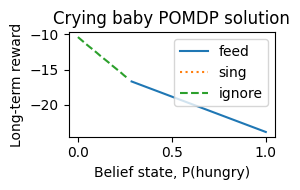

In [3]:
# Run the solver
q = Q(10)
v = np.max(q, axis=1, keepdims=True)
p = (q == v) * 1.0
v = v.squeeze(-1)

# Make the figure in the paper
from matplotlib import pyplot as plt
plt.figure(figsize=(3, 2))
plt.plot(B[p[:, 0] == 1], v[p[:, 0] == 1], label='feed')
plt.plot(B[p[:, 1] == 1], v[p[:, 1] == 1], ':', label='sing')
plt.plot(B[p[:, 2] == 1], v[p[:, 2] == 1], '--', label='ignore')
plt.legend()
plt.xlabel('Belief state, P(hungry)')
plt.ylabel('Long-term reward')
plt.title('Crying baby POMDP solution')
plt.tight_layout()
plt.savefig('../paper/fig/pomdp.pdf')